# Epsilon Stability and K (GAAS Subspace Dimension)

Here we investigate whether the dimension k of adversarial subspaces for AE tend to be larger than those of "clean" (unmodified) examples in the case when AE occupy the \epsilon-stable region of the clean example.  Part of our motivation is to determine whether "k-stability" is a reasonable detector for AE having small perturbation.

For a precise definition of \epsilon-stable, please see our writeup.

In [1]:
%matplotlib inline

import os
import time
import numpy as np
import pylab as plt
import pandas as pd
plt.rcParams['figure.figsize'] = (16,9)
from matplotlib import colors

In [12]:
def finite_part(x):
    "Returns a copy of x with all NaN elements removed."
    return x[np.isfinite(x)]


def scatter_finite(a, b, sigma=0):
    idx = np.isfinite(a) & np.isfinite(b)
    x = a[idx] + np.random.randn(np.sum(idx)) * sigma
    y = b[idx] + np.random.randn(np.sum(idx)) * sigma
    plt.scatter(x, y)


def estimate_epsilon_stability(df, e_id, dataset, fudge_factor=5.0, large_constant=4.0):
    """ Estimates the epsilon stability of a point.
    """
    # grab "gaussian" directions originating from the example
    subset = (df['Example#'] == e_id) & (df['direction_type'] == 'gaussian') & (df['Dataset'] == dataset)

    # Generate an estimate for the \epsilon stable region
    epsilon_est = np.min(df[subset]['boundary_distance'])
    
    # do something about inf distances
    epsilon_est = large_constant if not np.isfinite(epsilon_est) else epsilon_est
    
    # apply correction factor
    return epsilon_est / fudge_factor
    
    

def estimate_k_gaas(df, e_id, dataset, epsilon_ref):
    """ Estimates the largest dimension k of a local linear adversarial subspace.
    """
    # grab subset of data corresponding to this example/point type
    gaas_idx = (df['Example#'] == e_id) & (df['direction_type'] == 'gaas') & (df['Dataset'] == dataset)
    subset = df[gaas_idx]
    
    if len(subset) == 0:
        return None
    
    # Here we search for the largest value of k such that most of the
    # boundary distances are less than or equal to epsilon_ref.
    # i.e. we seek the largest subspace such that by moving no more than epsilon_ref
    # we are able to produce mostly AE with each basis vector.
    k_all = pd.unique(subset['k'])
    k_est = 0
    
    for idx, k in enumerate(k_all):
        tmp = subset[subset['k'] == k]
        freq = np.sum(tmp['boundary_distance'] <= epsilon_ref)
        #print(epsilon_ref, freq, k) # TEMP
        if freq < (k/2.0):
            break # too many directions were ineffective
        else:
            k_est = k
            
    #print(subset) # TEMP
    return k_est # the last value of k for which we were mostly unchanged in class label

In [15]:
#=================================================================================
# Load data
#=================================================================================

df = pd.read_pickle(os.path.expanduser("~/Data/Data_for_Evans_CIFAR_Experiments/Feb_9_2018_ell2/cifar10_stats_df_CH.pkl"))

print(df.dtypes.index)

all_datasets = pd.unique(df['Dataset'])
all_examples = pd.unique(df['Example#'])
all_examples = np.sort(all_examples)

d_max = np.max(finite_part(df['boundary_distance']))  # largest non-inf distance to a boundary


print('frame has %d datasets and %d unique examples' % (len(all_datasets), len(all_examples)))
print('k: ', pd.unique(df['k']))
print('d_max : ', d_max)
print(all_datasets)
df.head()

Index(['Approx_conf', 'Dataset', 'Example#', 'boundary_distance', 'delta_l2',
       'delta_loss', 'direction_id', 'direction_type', 'ell2_grad', 'k', 'y',
       'y_hat'],
      dtype='object')
frame has 21 datasets and 168 unique examples
k:  [ nan   2.   3.   4.   5.   7.  10.  15.  20.  30.]
d_max :  39.9985256663
['cifar10' 'FGM-10.00' 'FGM-2.50' 'FGM-5.00' 'I-FGM-1.50' 'I-FGM-10.00'
 'I-FGM-2.00' 'I-FGM-2.50' 'I-FGM-5.00' 'FGM-0.30' 'FGM-0.50' 'FGM-0.75'
 'FGM-1.00' 'FGM-1.50' 'FGM-2.00' 'I-FGM-0.30' 'I-FGM-0.50' 'I-FGM-0.75'
 'I-FGM-1.00' 'I-FGM-0.20' 'FGM-0.20']


,Approx_conf,Dataset,Example#,boundary_distance,delta_l2,delta_loss,direction_id,direction_type,ell2_grad,k,y,y_hat
0,2.384989,cifar10,0,2.248105,NaN,1.184469,NaN,gradient,0.484421,NaN,3,1.0
1,2.384989,cifar10,0,inf,NaN,NaN,NaN,neg-gradient,0.484421,NaN,3,NaN
2,2.384989,cifar10,0,10.786918,NaN,1.111750,NaN,gaussian,0.484421,NaN,3,6.0
3,2.384989,cifar10,0,16.394444,NaN,1.034890,NaN,gaussian,0.484421,NaN,3,6.0
4,2.384989,cifar10,0,16.801848,NaN,1.163014,NaN,gaussian,0.484421,NaN,3,6.0


In [14]:
#=================================================================================
# Compute stability estimates for each clean example.
#=================================================================================

epsilon_clean = np.zeros((len(all_examples),))
k_max_clean = np.zeros((len(all_examples),))

subset = df[df['Dataset'] == 'cifar10']  # speeds up calculations later

tic = time.time()
for idx, e_id in enumerate(all_examples):
    epsilon_clean[idx] = estimate_epsilon_stability(subset, e_id, 'cifar10', large_constant=2*d_max)
    k_max_clean[idx] = estimate_k_gaas(subset, e_id, 'cifar10', epsilon_clean[idx])
    
print('Took %0.2f seconds to compute stability metrics for clean' % (time.time() - tic))

Took 4.80 seconds to compute stability metrics for clean


there are 168 clean examples total


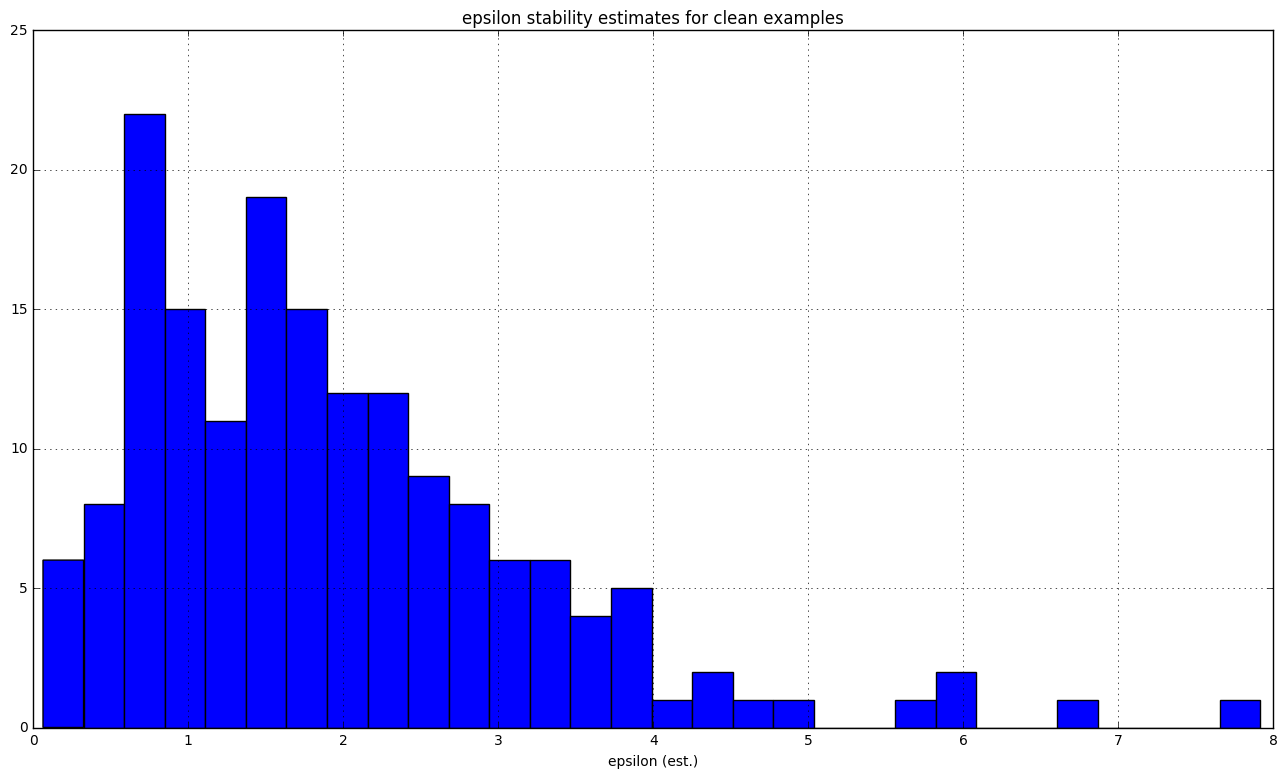

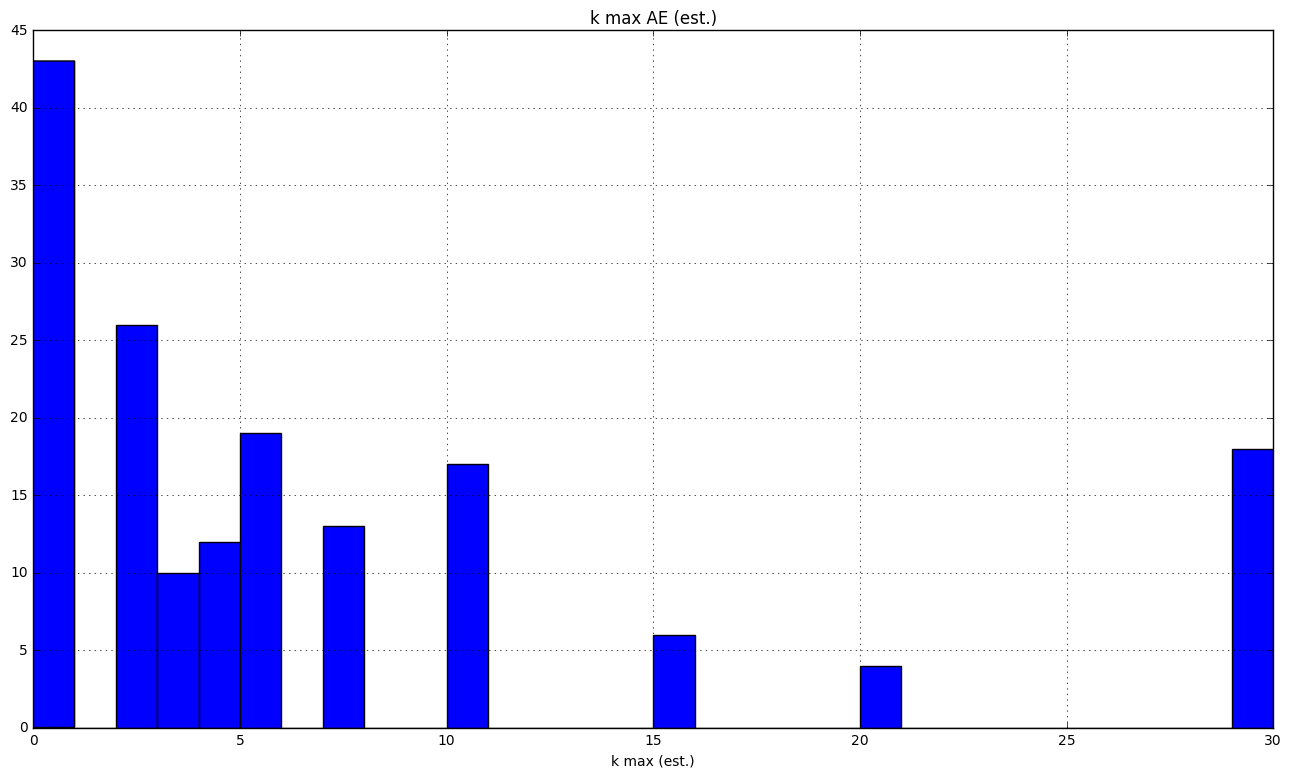

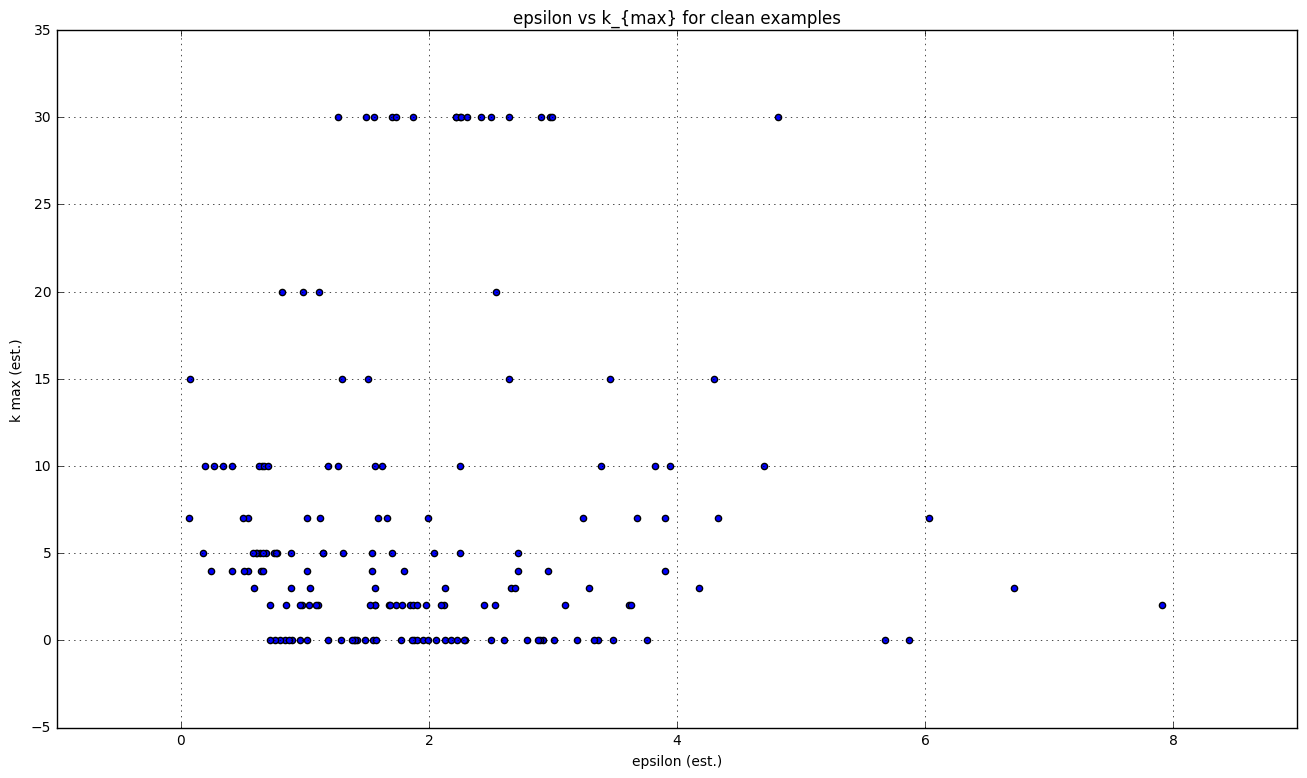

In [18]:
#=================================================================================
# Some statistics related to \epsilon-stability
#=================================================================================

print('there are %d clean examples total' % epsilon_clean.size)

plt.figure()
plt.hist(epsilon_clean, 30)
plt.xlabel('epsilon (est.)')
plt.title('epsilon stability estimates for clean examples')
plt.grid('on')


plt.figure()
plt.title('k max AE (est.)')
plt.hist(k_max_clean, 30)
plt.xlabel('k max (est.)')
plt.grid('on')

plt.figure()
plt.title('epsilon vs k_{max} for clean examples')
plt.scatter(epsilon_clean, k_max_clean)
plt.xlabel('epsilon (est.)')
plt.ylabel('k max (est.)')
plt.grid('on')

plt.show()


In [17]:
#=================================================================================
# Stability estimates for AE
#=================================================================================

delta_ae = {}
epsilon_ae = {}
k_max_ae = {}


tic = time.time()

for data_set in all_datasets:
    if data_set == 'cifar10':
        continue # we already did this above
        
    this_data_set = df[df['Dataset'] == data_set]
        
    epsilon_i = np.nan * np.zeros((len(all_examples),))
    k_max_i = np.nan * np.zeros((len(all_examples),))
    delta_i = np.nan * np.zeros((len(all_examples),))
    
    
    for idx, e_id in enumerate(all_examples):
        subset = this_data_set[this_data_set['Example#'] == e_id]
        
        if len(subset) == 0:
            continue
            
        delta_i = np.median(subset['delta_l2']) # these values should all be same; median just picks one
        epsilon_i[idx] = estimate_epsilon_stability(subset, e_id, data_set, large_constant=2*d_max)
        k_max_i[idx] = estimate_k_gaas(subset, e_id, data_set, epsilon_clean[idx])  # note: reference stability is for *clean* example!
        

    print('Finished with %s; net runtime: %0.2f sec' % (data_set, time.time()-tic))
    epsilon_ae[data_set] = epsilon_i
    k_max_ae[data_set] = k_max_i
    delta_ae[data_set] = delta_i
    
print('done: total runtime was %0.2f sec' % (time.time()-tic))

Finished with FGM-10.00; net runtime: 1.65 sec
Finished with FGM-2.50; net runtime: 3.16 sec
Finished with FGM-5.00; net runtime: 4.81 sec
Finished with I-FGM-1.50; net runtime: 6.08 sec
Finished with I-FGM-10.00; net runtime: 7.66 sec
Finished with I-FGM-2.00; net runtime: 9.00 sec
Finished with I-FGM-2.50; net runtime: 10.35 sec
Finished with I-FGM-5.00; net runtime: 11.78 sec
Finished with FGM-0.30; net runtime: 12.31 sec
Finished with FGM-0.50; net runtime: 13.05 sec
Finished with FGM-0.75; net runtime: 13.94 sec
Finished with FGM-1.00; net runtime: 14.87 sec
Finished with FGM-1.50; net runtime: 16.06 sec
Finished with FGM-2.00; net runtime: 17.36 sec
Finished with I-FGM-0.30; net runtime: 18.02 sec
Finished with I-FGM-0.50; net runtime: 18.93 sec
Finished with I-FGM-0.75; net runtime: 19.86 sec
Finished with I-FGM-1.00; net runtime: 20.96 sec
Finished with I-FGM-0.20; net runtime: 21.32 sec
Finished with FGM-0.20; net runtime: 21.64 sec
done: total runtime was 21.64 sec


5.9147602007 nan
25
102


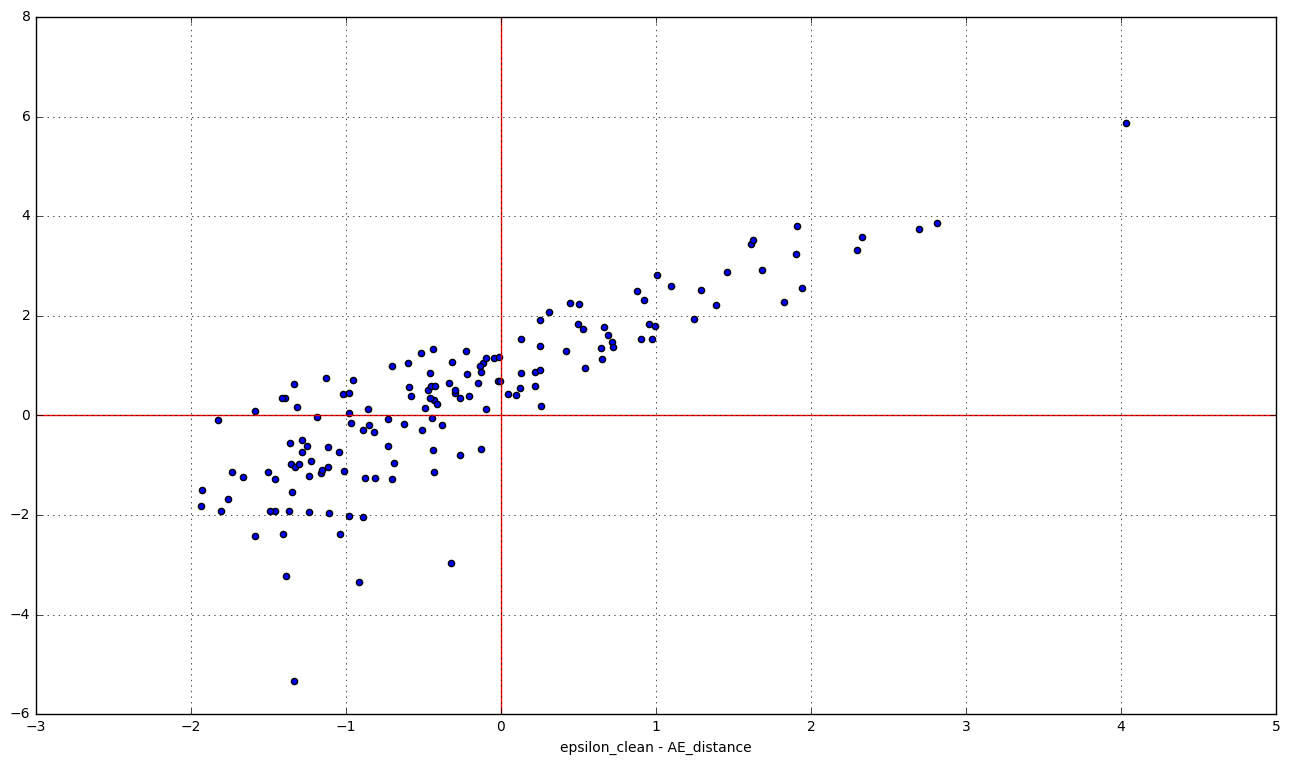

In [19]:
# Make sure we can reproduce Evan's nice local stability plot
# (to verfiy calculations above are consistent with his)

data_set = 'I-FGM-2.00'

plt.figure()
x = epsilon_clean - delta_ae[data_set]
y = epsilon_clean - epsilon_ae[data_set]


idx = np.argmax(x) # TEMP
print(x[idx], y[idx]) # TEMP
print(idx) # TEMP
print(all_examples[85]) # TEMP

plt.scatter(x,y)
plt.grid('on')
plt.xlabel('epsilon_clean - AE_distance')
plt.axhline(0, color='red')
plt.axvline(0, color='red')
plt.show()

In [ ]:
#=================================================================================
# Some statistics related to \epsilon-stability
#=================================================================================

DATA_TO_PLOT = [('FGM-2.00', 'I-FGM-2.00')]

for ds in DATA_TO_PLOT:
    plt.figure()
    for idx, ds_i in enumerate(ds):
        plt.subplot(1,len(ds),idx+1)
        plt.hist(finite_part(epsilon_ae[ds_i]), 30)
        plt.xlabel('$\epsilon$')
        plt.title('epsilon stability estimates for %s' % ds_i)
        plt.grid('on')
    
    ##
    plt.figure()
    for idx, ds_i in enumerate(ds):
        plt.subplot(1,len(ds),idx+1)
        tmp = delta_epsilon_ae[ds_i]; cnt = np.sum(np.isfinite(tmp))
        
        plt.plot(np.sort(tmp))
        plt.plot((0, cnt), (0, 0), 'r-')
        plt.grid('on')
        plt.title('epsilon_{clean} - epsilon_{%s}' % ds_i)
      
        
    ##
    plt.figure()
    for idx, ds_i in enumerate(ds):
        plt.subplot(1,len(ds),idx+1)
        scatter_finite(epsilon_clean, epsilon_ae[ds_i])
        plt.xlabel('epsilon_clean')
        plt.ylabel('epsilon_%s' % ds_i)
        
plt.show()

In [ ]:


for data_set in ['FGM-1.00', 'I-FGM-1.00']:
    n_points = len(finite_part(epsilon_ae[data_set]))
    print('dataset %s has %d admissible points' % (data_set, n_points))

    plt.figure()
    plt.hist(finite_part(epsilon_ae[data_set]), 30)
    plt.xlabel('$\epsilon$')
    plt.title('epsilon stability estimates for %s' % data_set)
    plt.grid('on')

    plt.figure()
    plt.hist(finite_part(k_max_ae[data_set]), 30)
    plt.xlabel('$\epsilon$')
    plt.title('k-max estimates for %s' % data_set)
    plt.grid('on')
    
    plt.figure()
    
    scatter_finite(epsilon_ae[data_set], k_max_ae[data_set])
    plt.xlabel('epsilon')
    plt.ylabel('k max')
    plt.grid('on')
    plt.title('epsilon vs k_{max} for %s' % data_set)
    
    plt.figure()
    plt.plot(np.sort(delta_epsilon_ae[data_set]))
    plt.grid('on')
    plt.title('epsilon_{clean} - epsilon_{%s}' % data_set)
    
    plt.figure()
    plt.plot(np.sort(delta_k_ae[data_set]))
    plt.grid('on')
    plt.title('k_max_{clean} - k_max_{%s}' % data_set)
    
    
    plt.figure()
    scatter_finite(epsilon_clean, epsilon_ae[data_set])
    plt.xlabel('epsilon_clean')
    plt.ylabel('epsilon_%s' % data_set)
    
    
    plt.figure()
    scatter_finite(k_max_clean, k_max_ae[data_set], 1)
    plt.grid('on')
    plt.xlabel('k_clean')
    plt.ylabel('k_%s' % data_set)
    
plt.show()